In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline


In [ ]:
#dados da questão
B = np.array([1.20,  1.19,  1.15,  1.13,  1.11,  1.08, 1.05,   1.02,  0.96,  0.85,  0.80,  0.75,  0.70,  0.60,   0.1,   0.0])
H = np.array([0.00, -5.00,-10.00,-15.00,-20.00,-25.00,-30.00,-35.00,-40.00,-45.00,-46.00,-47.00,-48.00,-49.00,-50.00,-52])*1e+3


Br = np.array([0, 1.2])
Hc = np.array([-52, 0])*1e+3

g0 = 1*1e-3
u0 = np.pi*4*1e-7
W = 4*1e-2
D = 3.5*1e-2
d = 8*1e-3
N1 = 1000
U0 = 4*np.pi*1e-7
Ur = (Br[0]- Br[1])/(Hc[0]-Hc[1])



0.00002308


### Considere inicialmente que não há corrente na bobina.
### Apresente um gráfico para a força magnética que surge no elemento
móvel nas condições a seguir:   
•Considerando uma aproximação linear da forma:  
$$
B_{\mathrm{m}} = \mu_{\mathrm{R}} (H_{\mathrm{m}} - H_{\mathrm{c}}^{\prime})
$$
•Considerando a curva BxH fornecida para o imã.


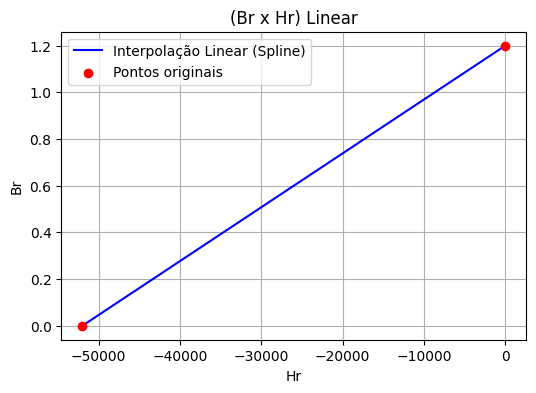

In [ ]:

Br = np.array([0, 1.2])
Hr = np.array([-52000, 0])

# Criar a função linear via spline natural
funcao_linear = CubicSpline(Hr, Br, bc_type='natural')

# Gerar vários pontos no intervalo para plotar a reta
x_vals = np.linspace(Hr.min(), Hr.max(), 100)
y_vals = funcao_linear(x_vals)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(x_vals, y_vals, label="Interpolação Linear (Spline)", color="blue")  # reta
plt.scatter(Hr, Br, color="red", zorder=5, label="Pontos originais")          # pontos dados
plt.xlabel("Hr")
plt.ylabel("Br")
plt.title("(Br x Hr) Linear")
plt.grid(True)
plt.legend()
plt.show()



Já para 